# Latent state estimation (filtering) for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

We show how to use cd-dynamax to estimate the latent state of a continuous-discrete (non-linear) Gaussian dynamical system

Specifically, we will showcase the following filtering alternatives:

- The Extended Kalman Filter (EKF)
- The Ensemble Kalman Filter (EnKF)
- The Unscented Kalman filter

## Preliminaries

### Code Setup

In [1]:
# Main imports
import sys
from itertools import count

# Import jax and utils
from jax import numpy as jnp
import jax.random as jr
from typing import Union
from jaxtyping import Float, Array

# Additional, custom codebase
sys.path.append("../..")
sys.path.append("../../..")

# Import dynamax
from dynamax.parameters import ParameterProperties
# import discrete-time filters
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

# Our own custom src codebase
# continuous-discrete nonlinear Gaussian SSM codebase
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter, cdnlgssm_forecast
# Load models
from continuous_discrete_nonlinear_gaussian_ssm.models import *

# Useful utility functions
from simulation_utils import *

# Plotting
import matplotlib
%matplotlib inline
# Our own custom plotting codebase
from utils.plotting_utils import *
from lorenz_plotting import *
# Feel free to change the default figure size
#matplotlib.rcParams['figure.figsize'] = [16, 9]

# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 430, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic z

## True model set up

We generate data from a Lorenz 63 system, from dynamics with the following stochastic differential equations:

\begin{align*}
\frac{d x}{d t} &= a(y-x) + \sigma w_x(t) \\
\frac{d y}{d t} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d z}{d t} &= xy - cz + \sigma w_z(t),
\end{align*}

With parameters $a=10, b=28, c=8/3$, the system gives rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

To generate data, we numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= H x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

Namely, we impose partial observability with H=[1, 0, 0], with noisy observations, sampled at irregular time intervals.

### True, data-generating model definition

In [2]:
## Main settings
state_dim = 3
emission_dim = 1

# Define a custom drift model, inherited from LearnableFunction
class lorenz63_drift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo

# Define the true parameters of the drift function
true_l63_drift_params = jnp.array([10.0, 28.0, 8 / 3])
# And the corresponding Lorenz 63 system
true_drift = {
    "params": lorenz63_drift(
        params=true_l63_drift_params
    ),
    "props": lorenz63_drift(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_coefficient_param = 0.1
true_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the emission function
# Partial observability
H=jnp.array(
    [[1.0, 0.0, 0.0]]
)
true_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(),
        bias=ParameterProperties()
    ),
}

# Define the true parameters of the emission covariance
R=jnp.eye(emission_dim)
true_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true initial mean and covariance
true_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties()
    ),
}

true_initial_cov_param = 10.0
true_initial_cov = {
    "params": LearnableMatrix(
        params=true_initial_cov_param*jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_true_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': true_initial_cov,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

# Simulation 1: Fast sample rate and modest initial state covariance

### Simulation set-up

In [3]:
# Set up seed for simulation
keys = map(jr.PRNGKey, count())

# Simulation parameters
T_filter = 40
T_total = 50
num_timesteps_total = 5000

# Generate time points for measurements, filtering and forecasting
sim1_t, sim1_t_filter, sim1_t_forecast, \
    sim1_num_timesteps, sim1_num_timesteps_filter, sim1_num_timesteps_forecast= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )


### Model creation: object instantiation, with modest initial state covariance

In [4]:
# Model parameters for simulation
# Initial covariance is "moderate"
sim1_state_sd = 10.0
sim1_initial_cov_param = {
    "params": LearnableMatrix(
        params=sim1_state_sd**2 *jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_sim1_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': sim1_initial_cov_param,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

# Create CD-NLGSSM model
sim1_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
sim1_params, _ = sim1_model.initialize(
    next(keys),
    **all_sim1_params
)

### Simulate data: sample from model

In [5]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.
sim1_states, sim1_emissions = sim1_model.sample(
    sim1_params,
    next(keys),
    sim1_num_timesteps,
    sim1_t,
    transition_type="path" # uses the Euler-Maruyama method
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


### Plot generated data

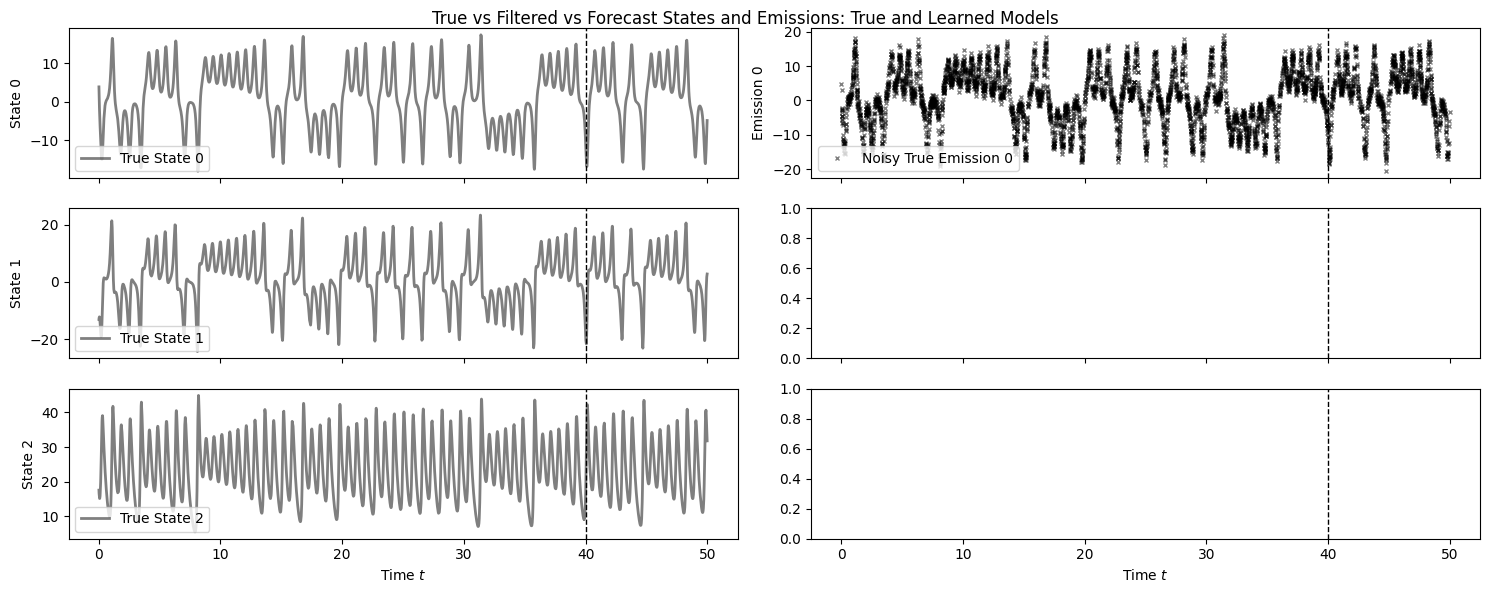

In [6]:
plot_advanced(
    time_grid_all=sim1_t,
    time_grid_filter=sim1_t_filter,
    time_grid_forecast=sim1_t_forecast,
    true_states=sim1_states,
    true_emissions_noisy=sim1_emissions,
    emission_function=sim1_params.emissions.emission_function
)

### State estimation with Extended Kalman Filter

In [7]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams

In [8]:
# Execute the EKF filter
sim1_ekf_filtered = cdnlgssm_filter(
    sim1_params,
    sim1_emissions[:sim1_num_timesteps_filter], # Filter based on the first part of the data
    sim1_t_filter,
    hyperparams=EKFHyperParams()
)


In [9]:
# Compute the emissions corresponding to the filtered states, according to the EKF filter
(sim1_ekf_filtered_emissions_means, sim1_ekf_filtered_emissions_covariance) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_filter,
    state_means = sim1_ekf_filtered.filtered_means,
    state_covs = sim1_ekf_filtered.filtered_covariances,
    inputs = None,
    hyperparams = EKFHyperParams(),
    key = next(keys),
)

In [10]:
# Compute the emissions corresponding to the filtered states, according to the model's emission function's mean
(sim1_ekf_filtered_emissions_expected, _) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_filter,
    state_means = sim1_ekf_filtered.filtered_means,
    state_covs = None,
    inputs = None,
    hyperparams = None,
    key = next(keys),
)

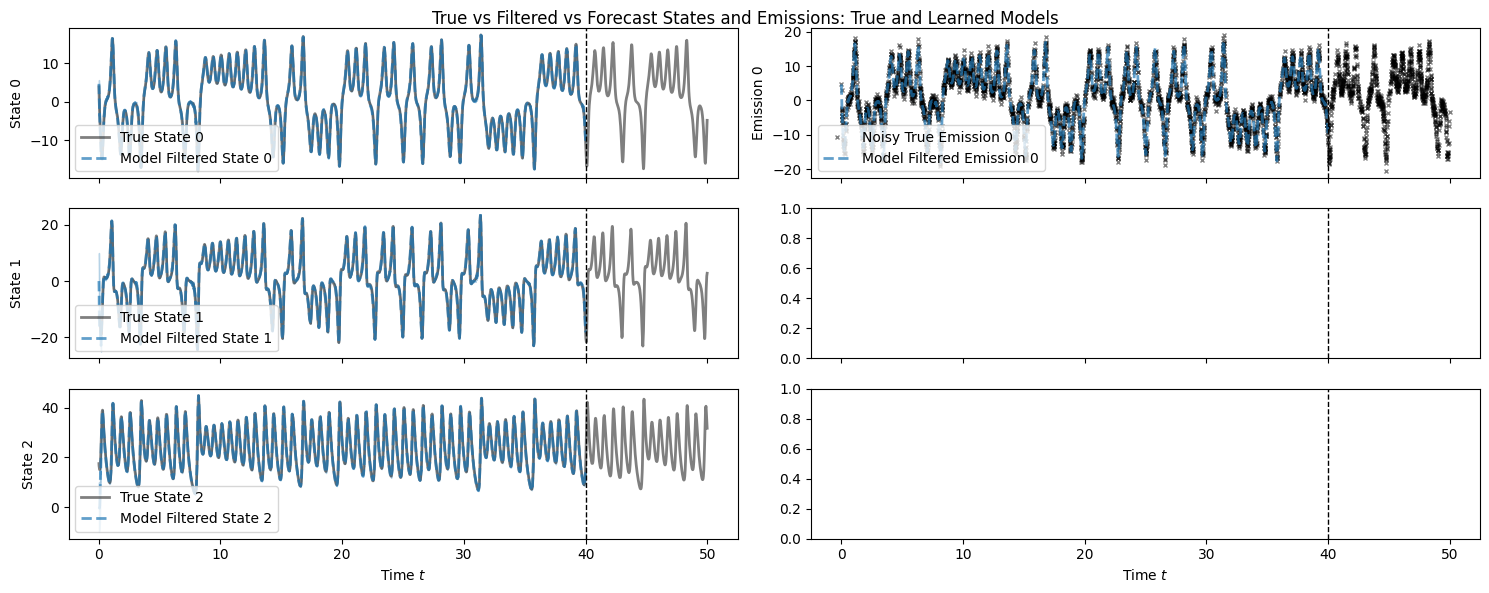

In [11]:
# Plot the true states and emissions, and the EKF estimates
plot_advanced(
        time_grid_all=sim1_t,
        time_grid_filter=sim1_t_filter,
        time_grid_forecast=sim1_t_forecast,
        true_states=sim1_states,
        true_emissions_noisy=sim1_emissions,
        emission_function=sim1_params.emissions.emission_function,
        model_filtered_states=sim1_ekf_filtered.filtered_means,
        model_filtered_covariances=sim1_ekf_filtered.filtered_covariances,
        t_start=None,
        t_end=None,
    )

In [12]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim1_states[:sim1_num_timesteps_filter, -1],
    sim1_ekf_filtered.filtered_means[:,-1],
    1,
    "EKF"
)

The RMSE of the EKF estimate is         : 0.92
The std of measurement noise is         : 1.00


In [13]:
# EKF forecasting: Distributional forecast
# Initialize at last filtered state's posterior Gaussian distribution 
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
ekf_init_forecast = MVN(
    sim1_ekf_filtered.filtered_means[-1,:],
    sim1_ekf_filtered.filtered_covariances[-1,:]
)
ekf_init_time = sim1_t_filter[-1]
# With this mean and covariance
print(ekf_init_time)
print(ekf_init_forecast.mean())
print(ekf_init_forecast.covariance())


[40.00]
[-10.22 -18.24 15.40]
[[0.07 0.09 -0.15]
 [0.09 0.11 -0.19]
 [-0.15 -0.19 0.32]]


In [14]:
# Execute the EKF forecast, using the last filtered state as initial forecast
sim1_ekf_forecast = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = ekf_init_forecast,
    t_init = ekf_init_time,
    t_forecast=sim1_t_forecast,
    hyperparams=EKFHyperParams()
)

In [15]:
# Compute the emissions corresponding to the forecasted states, according to the EKF filter
(sim1_ekf_forecast_emissions_means, sim1_ekf_forecast_emissions_covariance) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_forecast,
    state_means = sim1_ekf_forecast.forecasted_state_means,
    state_covs = sim1_ekf_forecast.forecasted_state_covariances,
    inputs = None,
    hyperparams = EKFHyperParams(),
    key = next(keys),
)

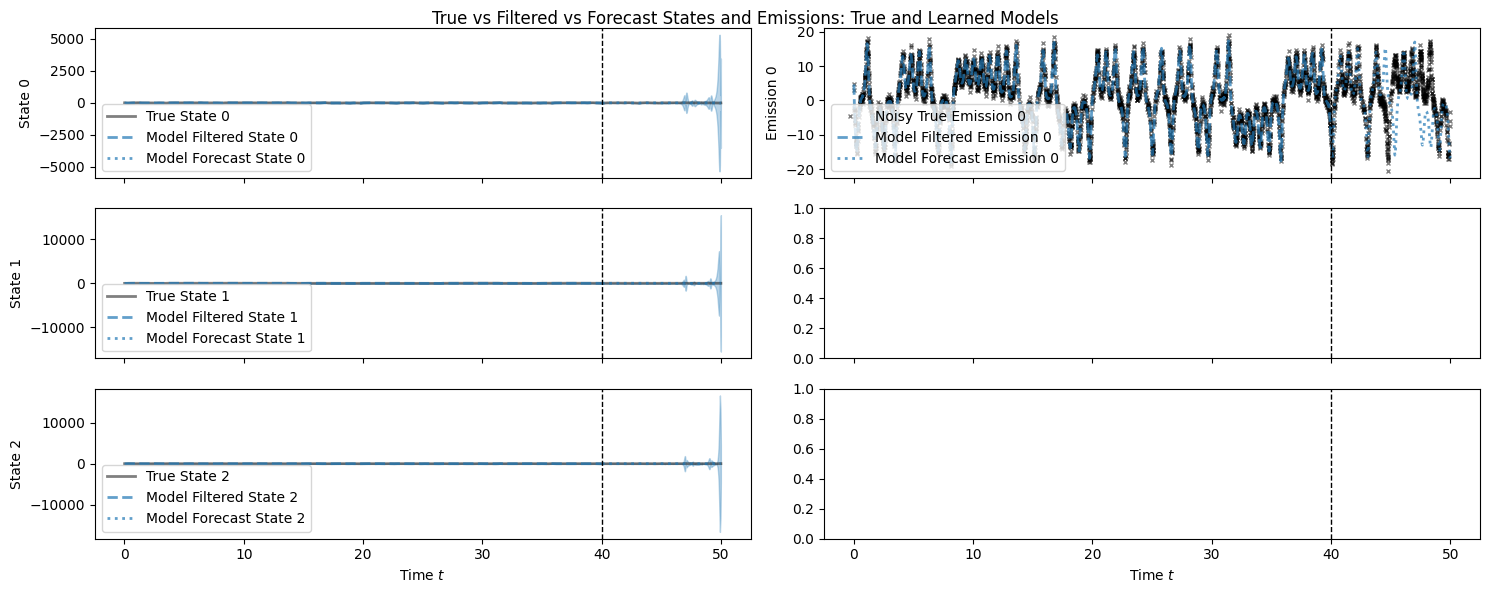

IndexError: index is out of bounds for axis 0 with size 0

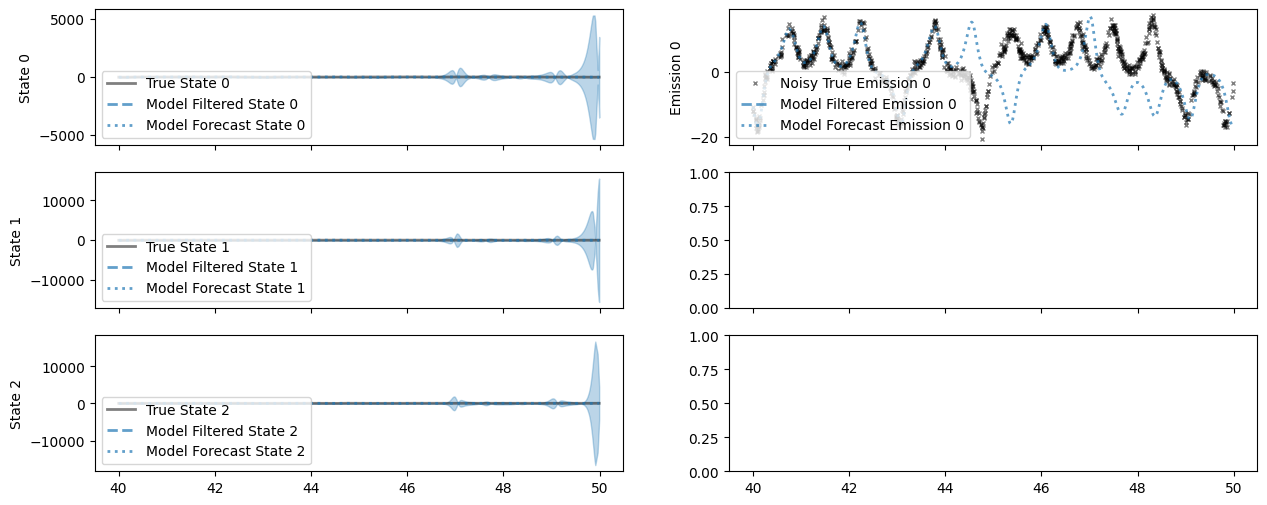

In [16]:
# Plot the true states and emissions, and the EKF estimates
for (t_start, t_end) in [(None, None), (T_filter, T_total)]:
    plot_advanced(
            time_grid_all=sim1_t,
            time_grid_filter=sim1_t_filter,
            time_grid_forecast=sim1_t_forecast,
            true_states=sim1_states,
            true_emissions_noisy=sim1_emissions,
            emission_function=sim1_params.emissions.emission_function,
            model_filtered_states=sim1_ekf_filtered.filtered_means,
            model_filtered_covariances=sim1_ekf_filtered.filtered_covariances,
            model_forecast_states=sim1_ekf_forecast.forecasted_state_means,
            model_forecast_covariances=sim1_ekf_forecast.forecasted_state_covariances,
            t_start=t_start,
            t_end=t_end,
        )

In [17]:
# EKF forecasting: Path-based forecast
# Initialize at last filtered state mean
ekf_init_path_forecast = sim1_ekf_filtered.filtered_means[-1,:]

In [18]:
# Execute the forecast, using EKF's last filtered mean state as initial forecast
sim1_forecast_ekf_path = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = ekf_init_path_forecast,
    t_init = ekf_init_time,
    t_forecast=sim1_t_forecast,
    hyperparams=EKFHyperParams(),
    key = next(keys)
)

In [19]:
# Compute the emissions corresponding to the forecasted state path, according to the model's emission function's mean
(sim1_ekf_filtered_emissions_expected, _) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_forecast,
    state_means = sim1_forecast_ekf_path.forecasted_state_path,
    state_covs = None,
    inputs = None,
    hyperparams = None,
    key = next(keys),
)

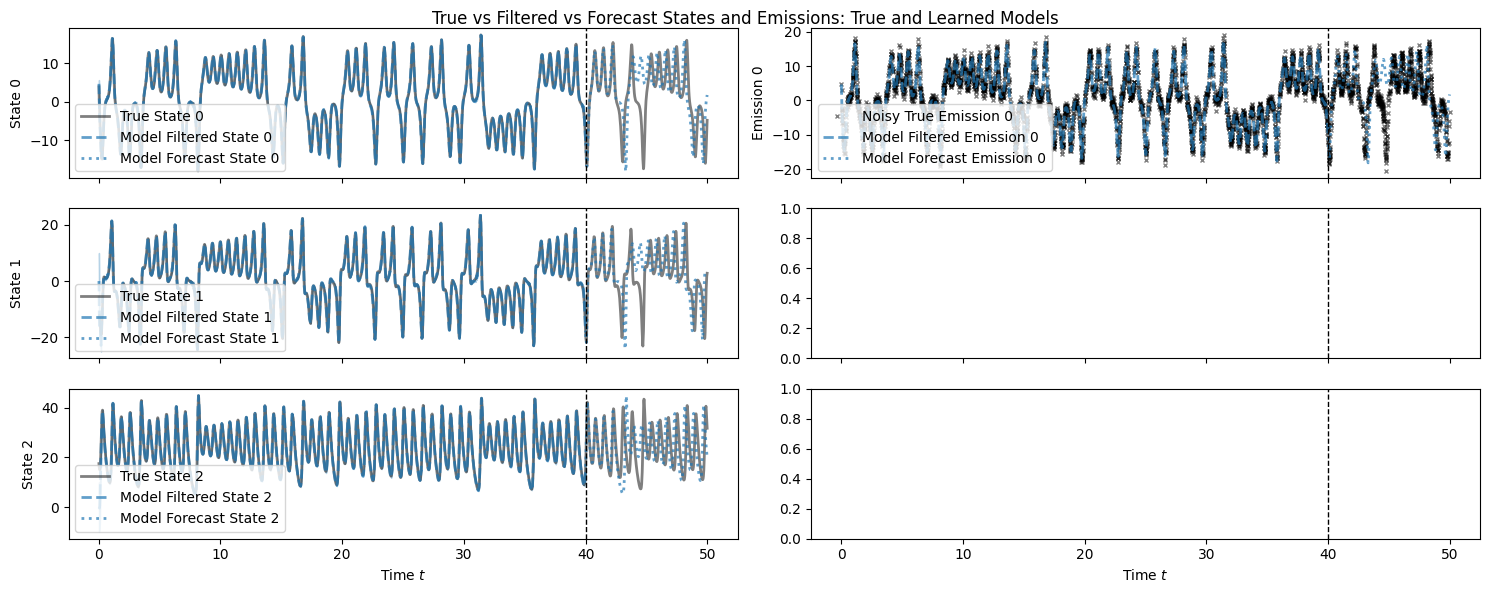

IndexError: index is out of bounds for axis 0 with size 0

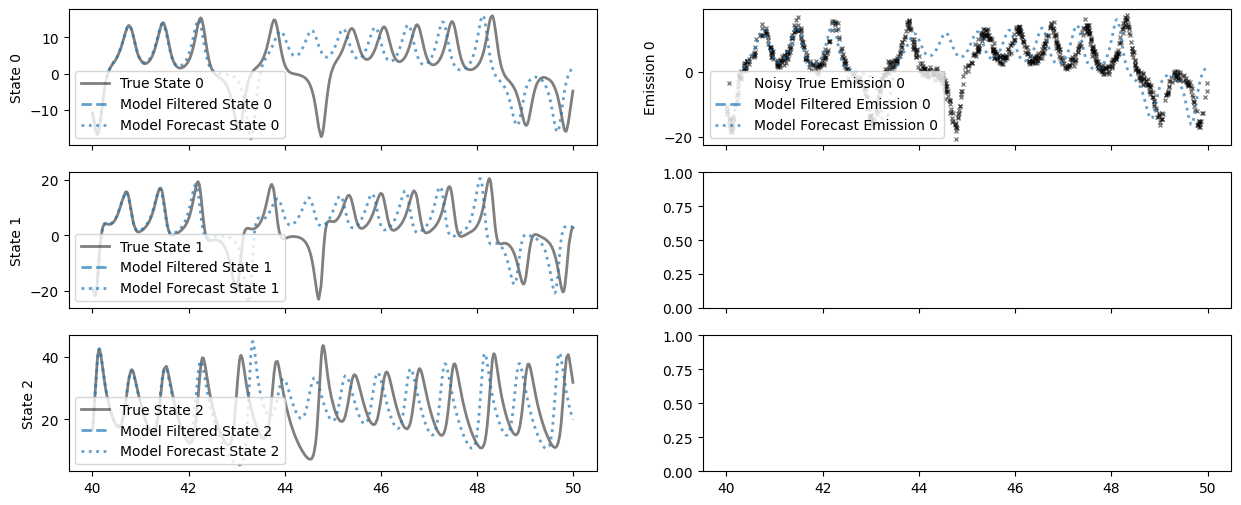

In [20]:
# Plot the true states and emissions, and the EKF estimates
for (t_start, t_end) in [(None, None), (T_filter, T_total)]:
    plot_advanced(
            time_grid_all=sim1_t,
            time_grid_filter=sim1_t_filter,
            time_grid_forecast=sim1_t_forecast,
            true_states=sim1_states,
            true_emissions_noisy=sim1_emissions,
            emission_function=sim1_params.emissions.emission_function,
            model_filtered_states=sim1_ekf_filtered.filtered_means,
            model_filtered_covariances=sim1_ekf_filtered.filtered_covariances,
            model_forecast_states=sim1_forecast_ekf_path.forecasted_state_path,
            t_start=t_start,
            t_end=t_end,
        )

### State estimation with Ensemble Kalman Filter

In [23]:
# Filter: EnKF
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams

In [24]:
# Execute the EnKF filter
sim1_enkf_filtered = cdnlgssm_filter(
    sim1_params,
    sim1_emissions[:sim1_num_timesteps_filter], # Filter based on the first part of the data
    sim1_t_filter,
    hyperparams=EnKFHyperParams()
)


In [25]:
# Compute the emissions corresponding to the filtered states, according to the EnKF filter
(sim1_enkf_filtered_emissions_means, sim1_enkf_filtered_emissions_covariance) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_filter,
    state_means = sim1_enkf_filtered.filtered_means,
    state_covs = sim1_enkf_filtered.filtered_covariances,
    inputs = None,
    hyperparams = EnKFHyperParams(),
    key = next(keys),
)

In [26]:
# Compute the emissions corresponding to the filtered states, according to the model's emission function's mean
(sim1_enkf_filtered_emissions_expected, _) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_filter,
    state_means = sim1_enkf_filtered.filtered_means,
    state_covs = None,
    inputs = None,
    hyperparams = None,
    key = next(keys),
)

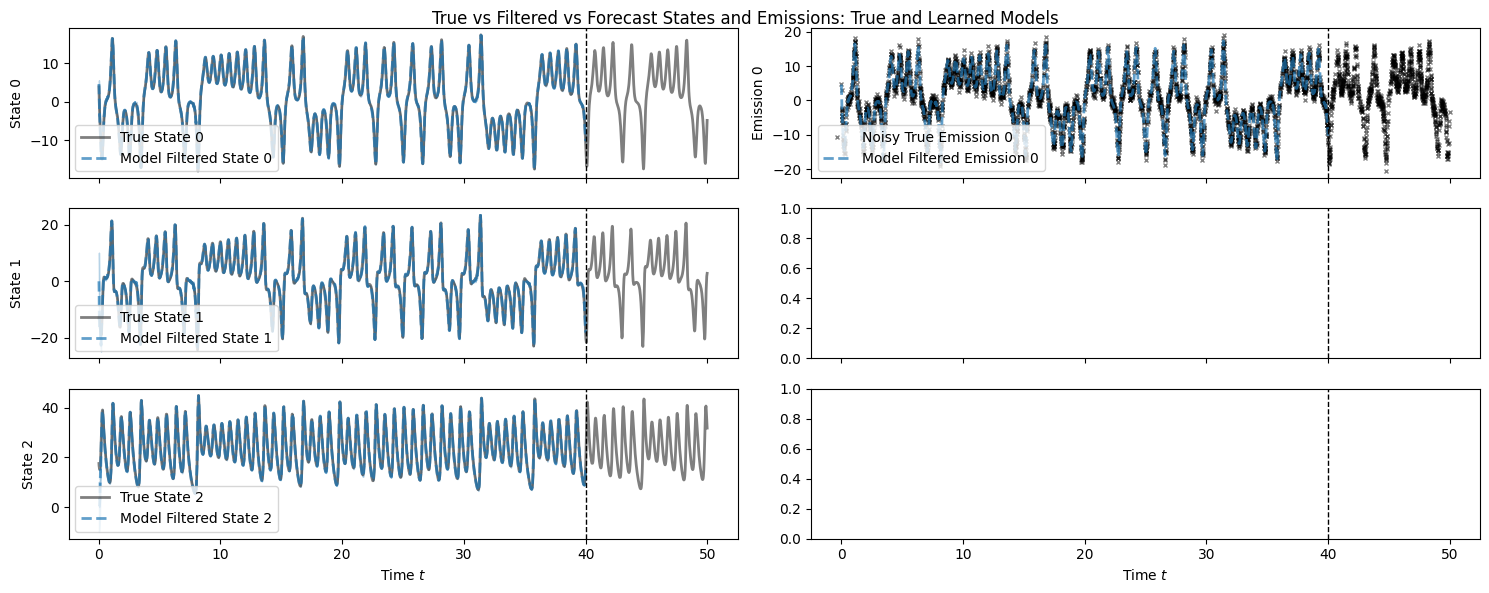

In [27]:
# Plot the true states and emissions, and the EnKF estimates
plot_advanced(
        time_grid_all=sim1_t,
        time_grid_filter=sim1_t_filter,
        time_grid_forecast=sim1_t_forecast,
        true_states=sim1_states,
        true_emissions_noisy=sim1_emissions,
        emission_function=sim1_params.emissions.emission_function,
        model_filtered_states=sim1_enkf_filtered.filtered_means,
        model_filtered_covariances=sim1_enkf_filtered.filtered_covariances,
        t_start=None,
        t_end=None,
    )

In [28]:
compute_and_print_rmse_comparison(
    sim1_states[:sim1_num_timesteps_filter, -1],
    sim1_ekf_filtered.filtered_means[:,-1],
    1,
    "EnKF"
)

The RMSE of the EnKF estimate is        : 0.92
The std of measurement noise is         : 1.00


In [29]:
# EnKF forecasting: Distributional forecast
# Initialize at last filtered state's posterior Gaussian distribution 
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
enkf_init_forecast = MVN(
    sim1_enkf_filtered.filtered_means[-1,:],
    sim1_enkf_filtered.filtered_covariances[-1,:]
)
enkf_init_time = sim1_t_filter[-1]
# With this mean and covariance
print(enkf_init_time)
print(enkf_init_forecast.mean())
print(enkf_init_forecast.covariance())


[40.00]
[-10.22 -18.21 15.44]
[[0.07 0.09 -0.15]
 [0.09 0.11 -0.18]
 [-0.15 -0.18 0.32]]


In [30]:
# Execute the EnKF forecast, using the last filtered state as initial forecast
sim1_enkf_forecast = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = enkf_init_forecast,
    t_init = enkf_init_time,
    t_forecast=sim1_t_forecast,
    hyperparams=EnKFHyperParams()
)

In [31]:
# Compute the emissions corresponding to the forecasted states, according to the EnKF filter
(sim1_enkf_forecast_emissions_means, sim1_enkf_forecast_emissions_covariance) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_forecast,
    state_means = sim1_enkf_forecast.forecasted_state_means,
    state_covs = sim1_enkf_forecast.forecasted_state_covariances,
    inputs = None,
    hyperparams = EnKFHyperParams(),
    key = next(keys),
)

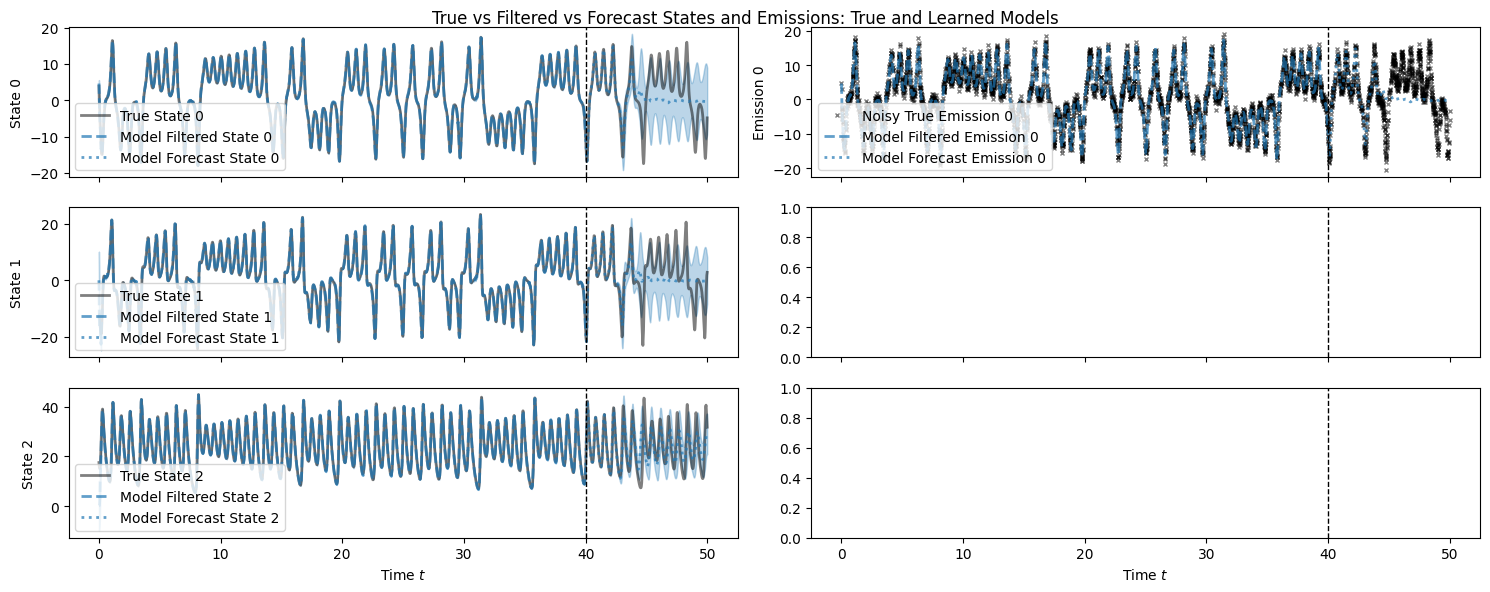

IndexError: index is out of bounds for axis 0 with size 0

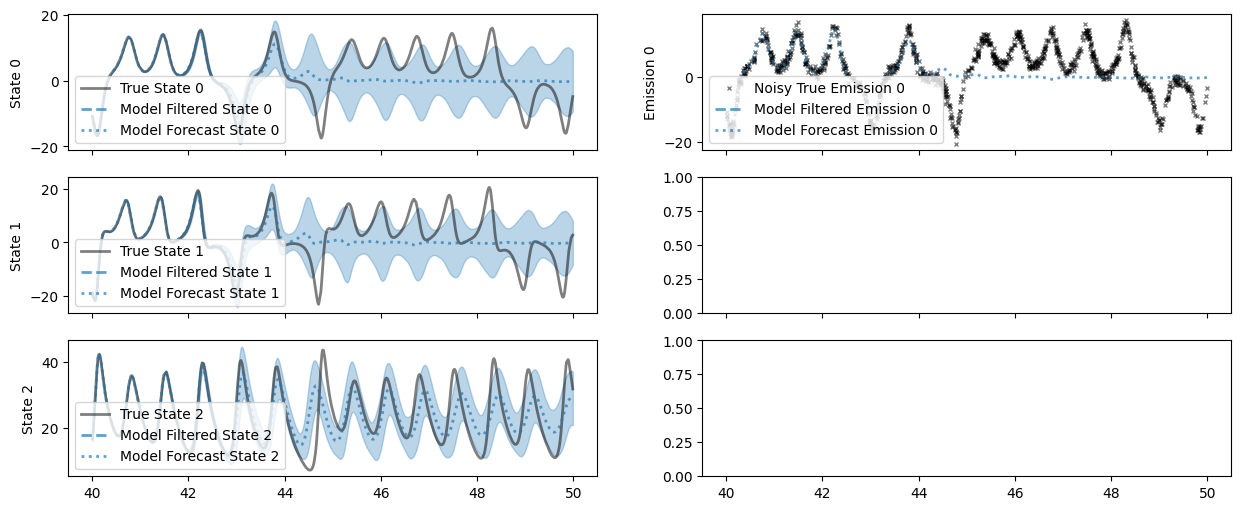

In [32]:
# Plot the true states and emissions, and the EnKF estimates
for (t_start, t_end) in [(None, None), (T_filter, T_total)]:
    plot_advanced(
            time_grid_all=sim1_t,
            time_grid_filter=sim1_t_filter,
            time_grid_forecast=sim1_t_forecast,
            true_states=sim1_states,
            true_emissions_noisy=sim1_emissions,
            emission_function=sim1_params.emissions.emission_function,
            model_filtered_states=sim1_enkf_filtered.filtered_means,
            model_filtered_covariances=sim1_enkf_filtered.filtered_covariances,
            model_forecast_states=sim1_enkf_forecast.forecasted_state_means,
            model_forecast_covariances=sim1_enkf_forecast.forecasted_state_covariances,
            t_start=t_start,
            t_end=t_end,
        )

In [33]:
# EnKF forecasting: Path-based forecast
# Initialize at last filtered state mean
enkf_init_path_forecast = sim1_enkf_filtered.filtered_means[-1,:]

In [34]:
# Execute the forecast, using EnKF's last filtered mean state as initial forecast
sim1_forecast_enkf_path = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = enkf_init_path_forecast,
    t_init = enkf_init_time,
    t_forecast=sim1_t_forecast,
    hyperparams=EnKFHyperParams(),
    key = next(keys)
)

In [35]:
# Compute the emissions corresponding to the forecasted state path, according to the model's emission function's mean
(sim1_enkf_filtered_emissions_expected, _) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_forecast,
    state_means = sim1_forecast_enkf_path.forecasted_state_path,
    state_covs = None,
    inputs = None,
    hyperparams = None,
    key = next(keys),
)

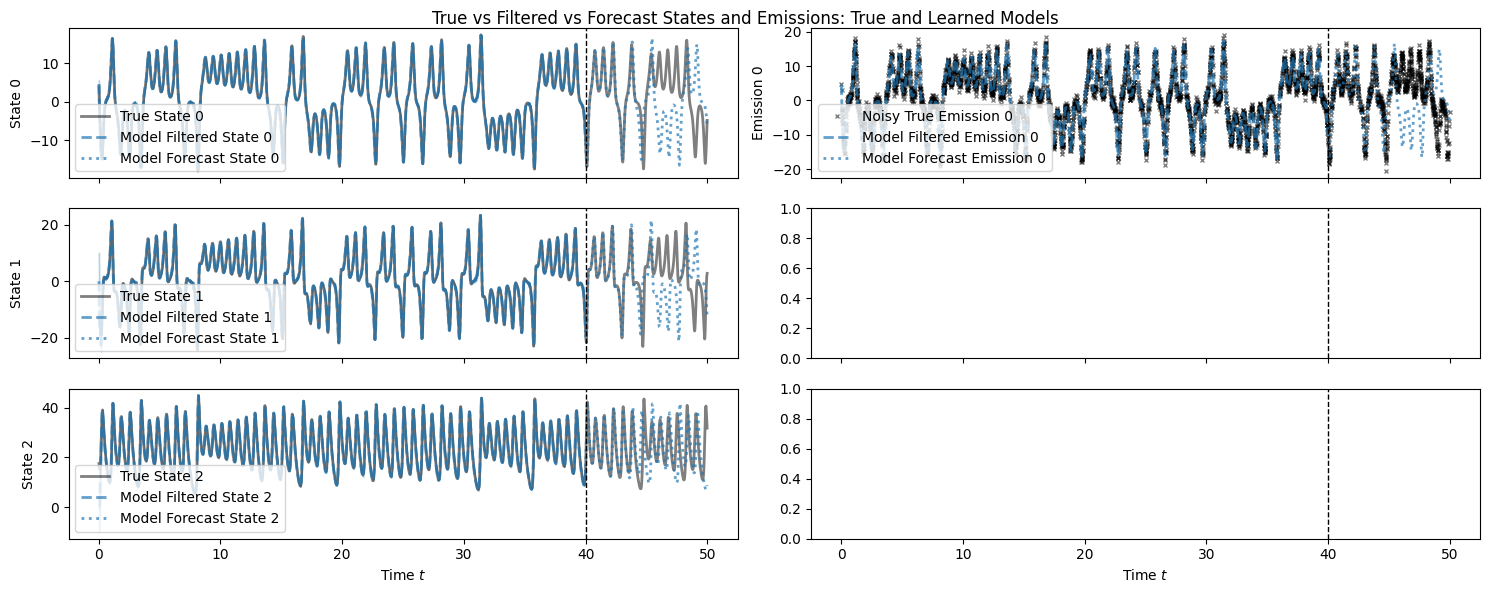

IndexError: index is out of bounds for axis 0 with size 0

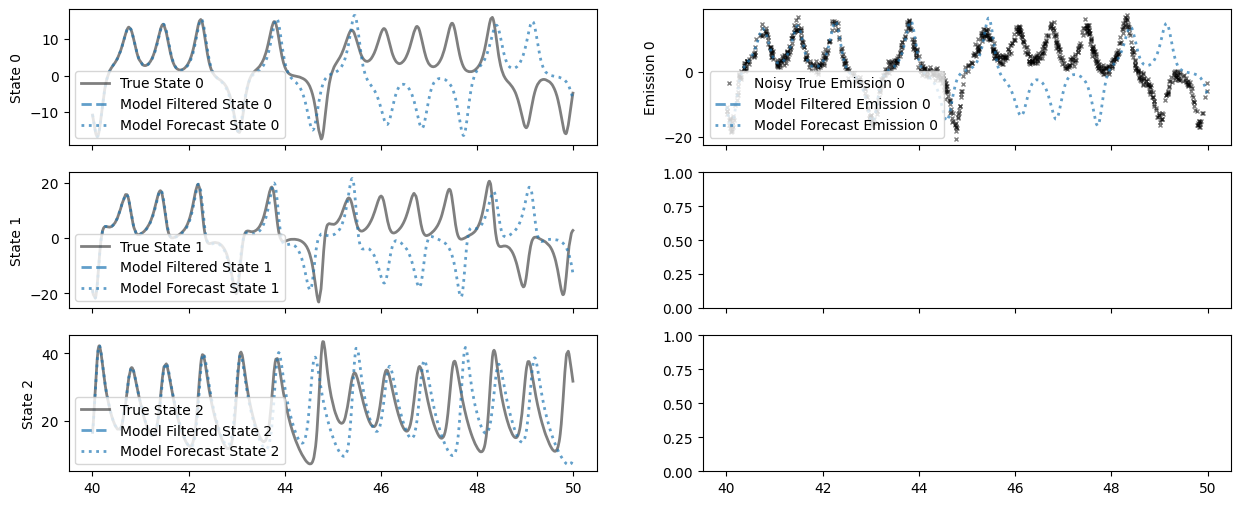

In [36]:
# Plot the true states and emissions, and the EnKF estimates
for (t_start, t_end) in [(None, None), (T_filter, T_total)]:
    plot_advanced(
            time_grid_all=sim1_t,
            time_grid_filter=sim1_t_filter,
            time_grid_forecast=sim1_t_forecast,
            true_states=sim1_states,
            true_emissions_noisy=sim1_emissions,
            emission_function=sim1_params.emissions.emission_function,
            model_filtered_states=sim1_enkf_filtered.filtered_means,
            model_filtered_covariances=sim1_enkf_filtered.filtered_covariances,
            model_forecast_states=sim1_forecast_enkf_path.forecasted_state_path,
            t_start=t_start,
            t_end=t_end,
        )

### State estimation with Uscented Kalman Filter

In [37]:
# Filter: UKF
from continuous_discrete_nonlinear_gaussian_ssm import UKFHyperParams

In [38]:
# Execute the UKF filter
sim1_ukf_filtered = cdnlgssm_filter(
    sim1_params,
    sim1_emissions,
    sim1_t_filter,
    hyperparams=UKFHyperParams()
)

In [39]:
# Compute the emissions corresponding to the filtered states, according to the UKF filter
(sim1_ukf_filtered_emissions_means, sim1_ukf_filtered_emissions_covariance) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_filter,
    state_means = sim1_ukf_filtered.filtered_means,
    state_covs = sim1_ukf_filtered.filtered_covariances,
    inputs = None,
    hyperparams = UKFHyperParams(),
    key = next(keys),
)

In [40]:
# Compute the emissions corresponding to the filtered states, according to the model's emission function's mean
(sim1_ukf_filtered_emissions_expected, _) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_filter,
    state_means = sim1_ukf_filtered.filtered_means,
    state_covs = None,
    inputs = None,
    hyperparams = None,
    key = next(keys),
)

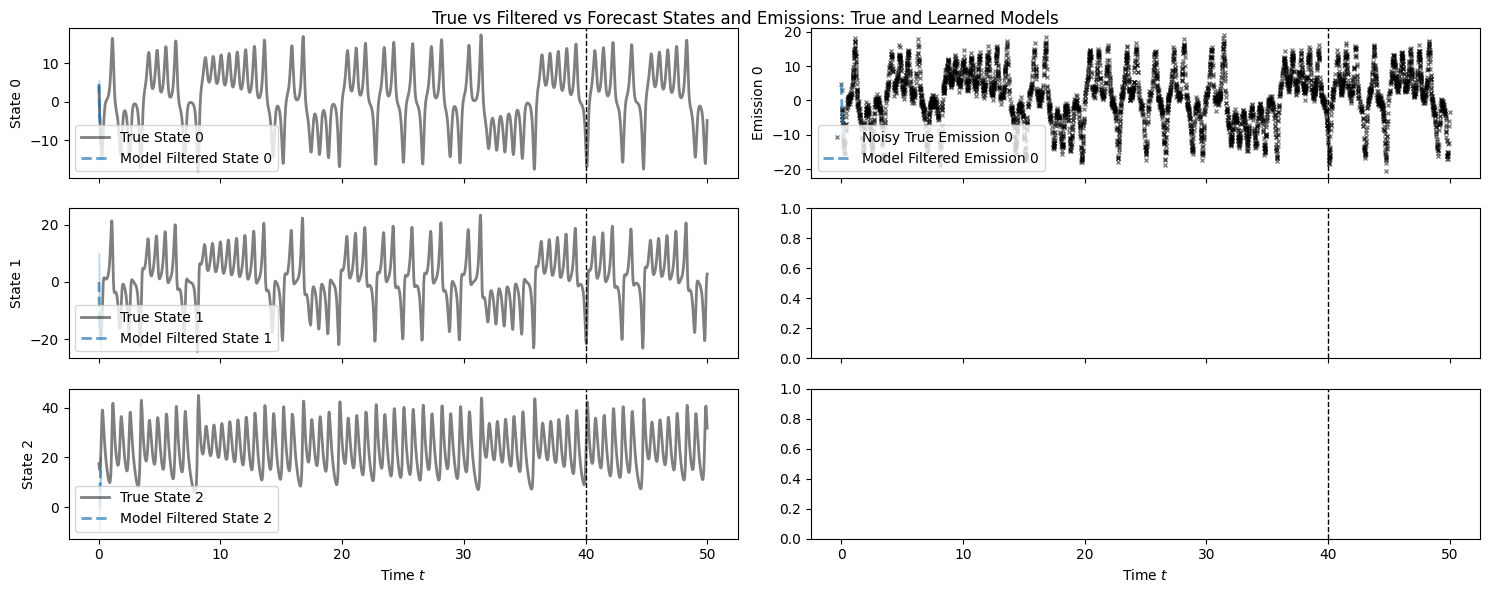

In [41]:
# Plot the true states and emissions, and the UKF estimates
plot_advanced(
        time_grid_all=sim1_t,
        time_grid_filter=sim1_t_filter,
        time_grid_forecast=sim1_t_forecast,
        true_states=sim1_states,
        true_emissions_noisy=sim1_emissions,
        emission_function=sim1_params.emissions.emission_function,
        model_filtered_states=sim1_ukf_filtered.filtered_means,
        model_filtered_covariances=sim1_ukf_filtered.filtered_covariances,
        t_start=None,
        t_end=None,
    )

In [42]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim1_states[:sim1_num_timesteps_filter, -1],
    sim1_ukf_filtered.filtered_means[:,-1],
    1,
    "UKF"
)

The RMSE of the UKF estimate is         : nan
The std of measurement noise is         : 1.00


In [43]:
# UKF forecasting: Distributional forecast
# Initialize at last filtered state's posterior Gaussian distribution 
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
ukf_init_forecast = MVN(
    sim1_ukf_filtered.filtered_means[-1,:],
    sim1_ukf_filtered.filtered_covariances[-1,:]
)
ukf_init_time = sim1_t_filter[-1]
# With this mean and covariance
print(ukf_init_time)
print(ukf_init_forecast.mean())
print(ukf_init_forecast.covariance())


[40.00]
[nan nan nan]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [44]:
# Execute the UKF forecast, using the last filtered state as initial forecast
sim1_ukf_forecast = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = ukf_init_forecast,
    t_init = ukf_init_time,
    t_forecast=sim1_t_forecast,
    hyperparams=UKFHyperParams()
)

In [45]:
# Compute the emissions corresponding to the forecasted states, according to the UKF filter
(sim1_ukf_forecast_emissions_means, sim1_ukf_forecast_emissions_covariance) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_forecast,
    state_means = sim1_ukf_forecast.forecasted_state_means,
    state_covs = sim1_ukf_forecast.forecasted_state_covariances,
    inputs = None,
    hyperparams = UKFHyperParams(),
    key = next(keys),
)

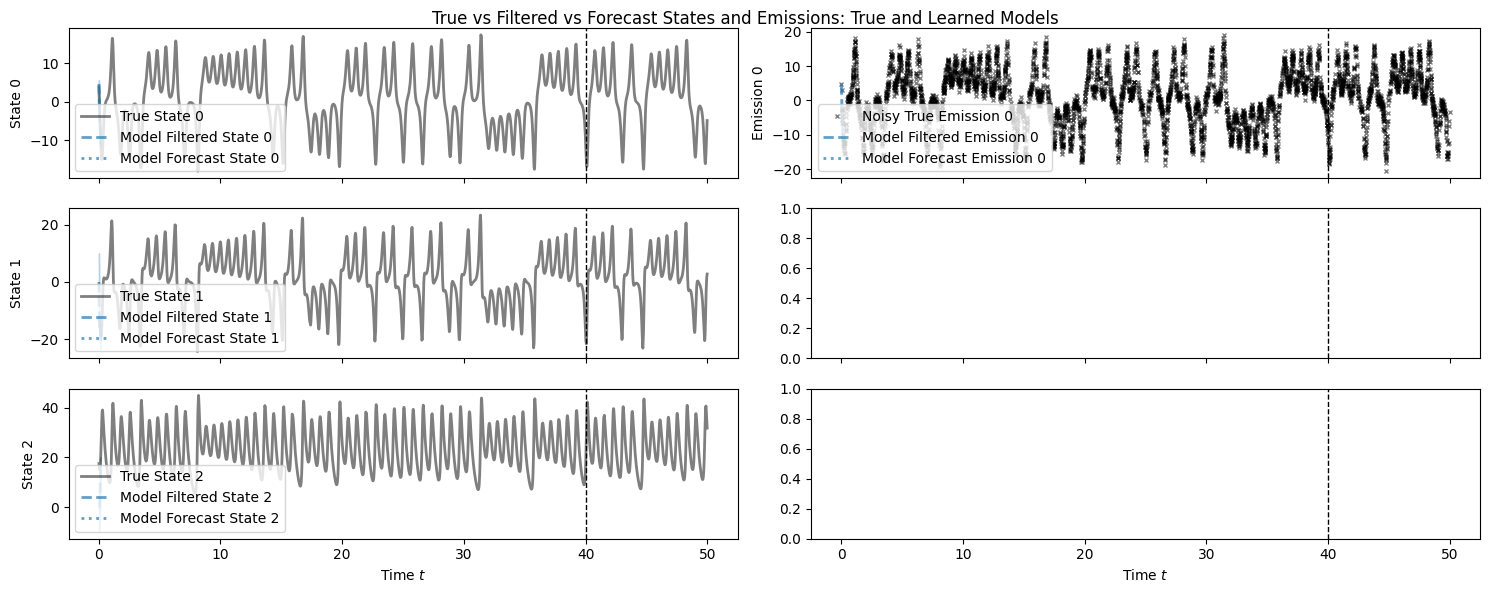

IndexError: index is out of bounds for axis 0 with size 0

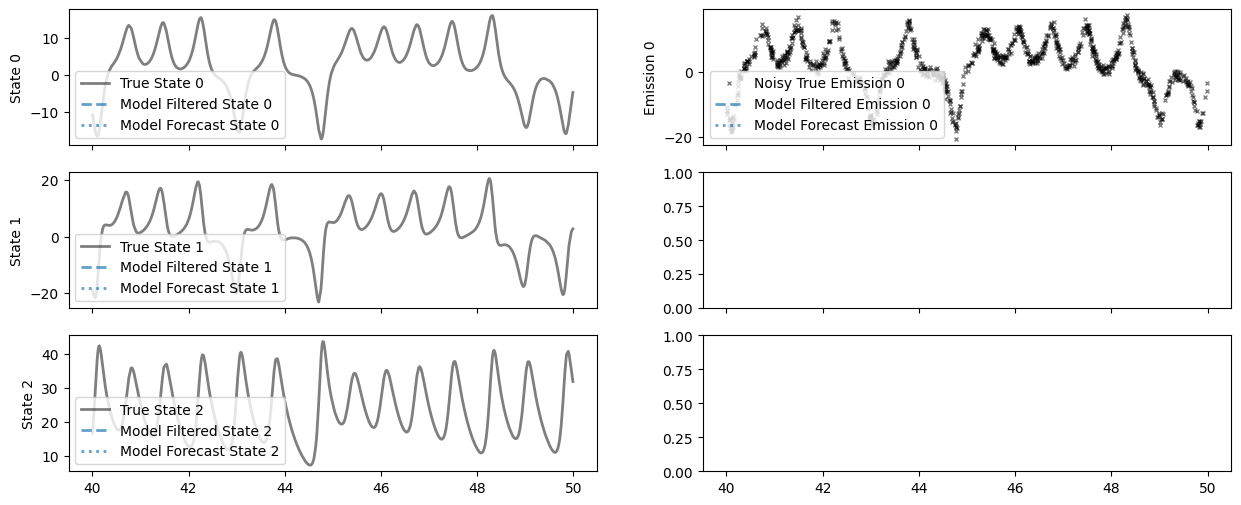

In [46]:
# Plot the true states and emissions, and the UKF estimates
for (t_start, t_end) in [(None, None), (T_filter, T_total)]:
    plot_advanced(
            time_grid_all=sim1_t,
            time_grid_filter=sim1_t_filter,
            time_grid_forecast=sim1_t_forecast,
            true_states=sim1_states,
            true_emissions_noisy=sim1_emissions,
            emission_function=sim1_params.emissions.emission_function,
            model_filtered_states=sim1_ukf_filtered.filtered_means,
            model_filtered_covariances=sim1_ukf_filtered.filtered_covariances,
            model_forecast_states=sim1_ukf_forecast.forecasted_state_means,
            model_forecast_covariances=sim1_ukf_forecast.forecasted_state_covariances,
            t_start=t_start,
            t_end=t_end,
        )

In [47]:
# UKF forecasting: Path-based forecast
# Initialize at last filtered state mean
ukf_init_path_forecast = sim1_ukf_filtered.filtered_means[-1,:]

In [48]:
# Execute the forecast, using EKF's last filtered mean state as initial forecast
sim1_forecast_ukf_path = cdnlgssm_forecast(
    params = sim1_params,
    init_forecast = ukf_init_path_forecast,
    t_init = ukf_init_time,
    t_forecast=sim1_t_forecast,
    hyperparams=UKFHyperParams(),
    key = next(keys)
)

In [49]:
# Compute the emissions corresponding to the forecasted state path, according to the model's emission function's mean
(sim1_ukf_filtered_emissions_expected, _) = cdnlgssm_emissions(
    params = sim1_params,
    t_states = sim1_t_forecast,
    state_means = sim1_forecast_ukf_path.forecasted_state_path,
    state_covs = None,
    inputs = None,
    hyperparams = None,
    key = next(keys),
)

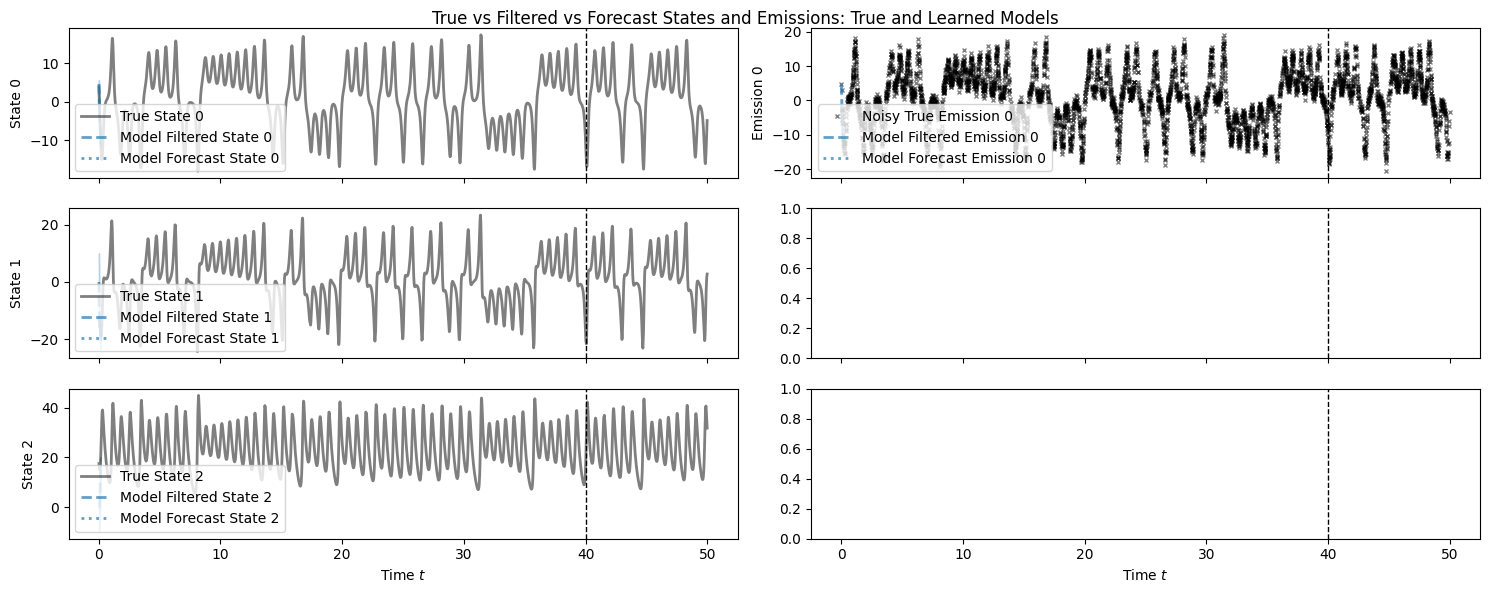

IndexError: index is out of bounds for axis 0 with size 0

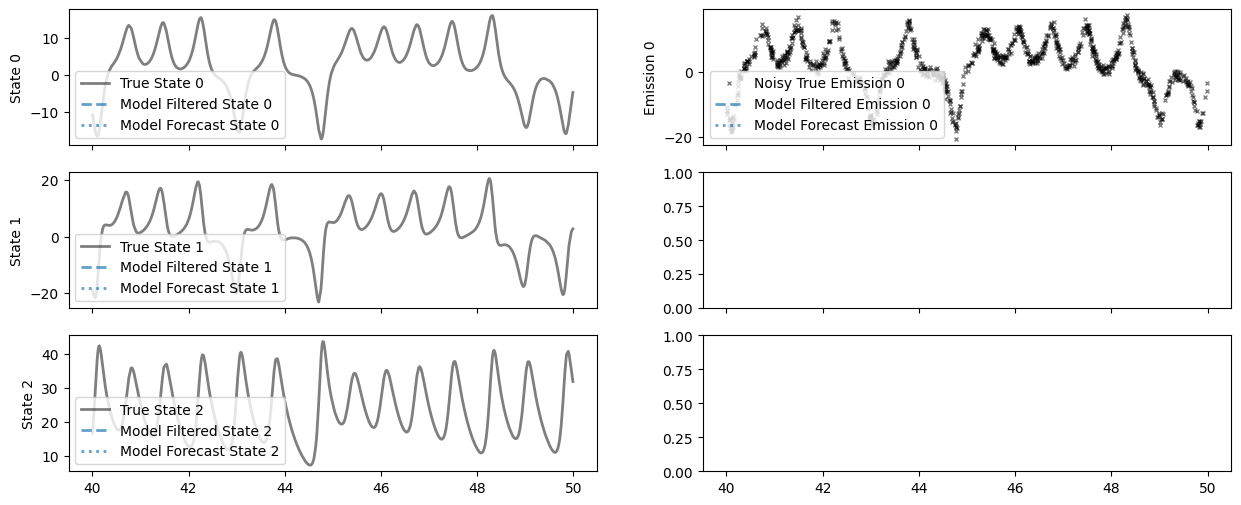

In [50]:
# Plot the true states and emissions, and the UKF estimates
for (t_start, t_end) in [(None, None), (T_filter, T_total)]:
    plot_advanced(
            time_grid_all=sim1_t,
            time_grid_filter=sim1_t_filter,
            time_grid_forecast=sim1_t_forecast,
            true_states=sim1_states,
            true_emissions_noisy=sim1_emissions,
            emission_function=sim1_params.emissions.emission_function,
            model_filtered_states=sim1_ukf_filtered.filtered_means,
            model_filtered_covariances=sim1_ukf_filtered.filtered_covariances,
            model_forecast_states=sim1_forecast_ukf_path.forecasted_state_path,
            t_start=t_start,
            t_end=t_end,
        )

# Simulation 2: Slow sample rate and larger initial state covariance

### Simulation set-up

In [ ]:
# Set up seed for simulation
keys = map(jr.PRNGKey, count())

# Simulation parameters
T_filter_2 = 40
T_total_2 = 50
num_timesteps_total_2 = 500

# Generate time points for measurements, filtering and forecasting
sim2_t, sim2_t_filter, sim2_t_forecast, \
    sim2_num_timesteps, sim2_num_timesteps_filter, sim2_num_timesteps_forecast= \
    generate_irregular_t_emissions(
        T_total=T_total_2,
        num_timesteps=num_timesteps_total_2,
        T_filter=T_filter_2,
        key=next(keys)
    )

### Model creation: object instantiation, with modest initial state covariance

In [24]:
# slightly bigger initial covariance
sim2_state_sd = 20.0
# Defining the parameters of the initial covariance
sim2_initial_cov_param = {
    "params": LearnableMatrix(
        params=sim2_state_sd**2 *jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_sim2_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': sim2_initial_cov_param,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

# Create CD-NLGSSM model
sim2_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
sim2_params, _ = sim1_model.initialize(
    next(keys),
    **all_sim1_params
)

### Simulate data: sample from model

In [ ]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.
sim2_states, sim2_emissions = sim2_model.sample(
    sim2_params,
    next(keys),
    sim2_num_timesteps,
    sim2_t_emissions,
    transition_type="path" # uses the Euler-Maruyama method
)

## TODO: replicate all above, once settled

### Plot generated data

In [ ]:
plot_lorenz(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions
)

### State estimation with Extended Kalman Filter

In [27]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams

In [28]:
# Execute the EKF filter
sim2_ekf_filtered = cdnlgssm_filter(
    sim2_params,
    sim2_emissions,
    sim2_t_emissions,
    hyperparams=EKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the EKF estimates
plot_advanced(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions,
    x_est=sim2_ekf_filtered.filtered_means,
    x_unc=sim2_ekf_filtered.filtered_covariances,
    est_type="EKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim2_states[:, -1],
    sim2_ekf_filtered.filtered_means[:,-1],
    1,
    "EKF"
)

### State estimation with Ensemble Kalman Filter

In [31]:
# Filter: EnKF
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams

In [ ]:
# Execute the EnKF filter
sim2_enkf_filtered = cdnlgssm_filter(
    sim2_params,
    sim2_emissions,
    sim2_t_emissions,
    hyperparams=EnKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the EKF estimates
plot_advanced(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions,
    x_est=sim2_enkf_filtered.filtered_means,
    x_unc=sim2_enkf_filtered.filtered_covariances,
    est_type="EnKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim2_states[:, -1],
    sim2_enkf_filtered.filtered_means[:,-1],
    1,
    "EnKF"
)

### State estimation with Uscented Kalman Filter

In [32]:
# Filter: UKF
from continuous_discrete_nonlinear_gaussian_ssm import UKFHyperParams

In [33]:
# Execute the UKF filter
sim2_ukf_filtered = cdnlgssm_filter(
    sim2_params,
    sim2_emissions,
    sim2_t_emissions,
    hyperparams=UKFHyperParams()
)


In [ ]:
# Plot the true states and emissions, and the UKF estimates
plot_advanced(
    sim2_t_emissions,
    sim2_states,
    sim2_emissions,
    x_est=sim2_ukf_filtered.filtered_means,
    x_unc=sim2_ukf_filtered.filtered_covariances,
    est_type="UKF"
)

In [ ]:
### Compute and print RMSE between true states and EKF estimates
compute_and_print_rmse_comparison(
    sim2_states[:, -1],
    sim2_ukf_filtered.filtered_means[:,-1],
    1,
    "UKF"
)